<a href="https://colab.research.google.com/github/arijitaurko/See-in-the-Dark-using-CNN/blob/main/Learning_to_See_in_the_Dark_DeepLearning_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning to See-in-the-Dark using Fully-Connected Convolutional Neural Network

*   Importing necessary libraries



In [ ]:
!pip install rawpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import rawpy, random, os, cv2

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import UpSampling2D, Conv2D, MaxPooling2D, Dropout, concatenate, BatchNormalization
from tensorflow.keras.layers import Layer, LeakyReLU, Conv2DTranspose, Concatenate, Dense
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.utils import plot_model

%matplotlib inline

* Check the GPU Status

In [ ]:
!nvidia-smi

Thu Oct 12 07:55:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

* Mounting Google Drive to import the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!wget https://storage.googleapis.com/isl-datasets/SID/Sony.zip -O '/content/dataset/Sony.zip'
#!unzip -q /content/dataset/Sony.zip -d /content/drive/MyDrive/DSML_Portfolio_Project/dataset/
#!rm /content/dataset/Sony.zip

In [ ]:
#BASE_PATH = '/content/drive/MyDrive/DSML_Portfolio_Project/dataset/'
BASE_PATH = '/content/drive/MyDrive/Scaler/Project/DSML_Portfolio_Project/dataset/'

data_train = pd.read_csv(BASE_PATH+'Sony_train_list.txt', sep = ' ', names = ['x', 'y', 'iso', 'f'])
data_test = pd.read_csv(BASE_PATH+'Sony_test_list.txt', sep = ' ', names = ['x', 'y', 'iso', 'f'])
data_val = pd.read_csv(BASE_PATH+'Sony_val_list.txt', sep = ' ', names = ['x', 'y', 'iso', 'f'])



data_train['x'] = BASE_PATH + data_train['x'].str.lstrip('.')
data_train['y'] = BASE_PATH + data_train['y'].str.lstrip('.')
print('Train : ', data_train.shape)

data_test['x'] = BASE_PATH + data_test['x'].str.lstrip('.')
data_test['y'] = BASE_PATH + data_test['y'].str.lstrip('.')
print('Test : ', data_test.shape)

data_val['x'] = BASE_PATH + data_val['x'].str.lstrip('.')
data_val['y'] = BASE_PATH + data_val['y'].str.lstrip('.')
print('Val : ', data_val.shape)
print()
print(data_train['x'][0])
print(data_train['y'][0])

Train :  (1865, 4)
Test :  (598, 4)
Val :  (234, 4)

/content/drive/MyDrive/Scaler/Project/DSML_Portfolio_Project/dataset//Sony/short/00001_00_0.04s.ARW
/content/drive/MyDrive/Scaler/Project/DSML_Portfolio_Project/dataset//Sony/long/00001_00_10s.ARW


In [ ]:
data_train.head(10)

x  \
0  /content/drive/MyDrive/Scaler/Project/DSML_Por...   
1  /content/drive/MyDrive/Scaler/Project/DSML_Por...   
2  /content/drive/MyDrive/Scaler/Project/DSML_Por...   
3  /content/drive/MyDrive/Scaler/Project/DSML_Por...   
4  /content/drive/MyDrive/Scaler/Project/DSML_Por...   
5  /content/drive/MyDrive/Scaler/Project/DSML_Por...   
6  /content/drive/MyDrive/Scaler/Project/DSML_Por...   
7  /content/drive/MyDrive/Scaler/Project/DSML_Por...   
8  /content/drive/MyDrive/Scaler/Project/DSML_Por...   
9  /content/drive/MyDrive/Scaler/Project/DSML_Por...   

                                                   y     iso   f  
0  /content/drive/MyDrive/Scaler/Project/DSML_Por...  ISO200  F8  
1  /content/drive/MyDrive/Scaler/Project/DSML_Por...  ISO200  F8  
2  /content/drive/MyDrive/Scaler/Project/DSML_Por...  ISO200  F8  
3  /content/drive/MyDrive/Scaler/Project/DSML_Por...  ISO200  F8  
4  /content/drive/MyDrive/Scaler/Project/DSML_Por...  ISO200  F8  
5  /content/drive/MyDrive/Scaler/Project/DSML_Por...  ISO200  F8  
6  /content/drive/MyDrive/Scaler/Project/DSML_Por...  ISO200  F8  
7  /content/drive/MyDrive/Scaler/Project/DSML_Por...  ISO200  F8  
8  /content/drive/MyDrive/Scaler/Project/DSML_Por...  ISO200  F8  
9  /content/drive/MyDrive/Scaler/Project/DSML_Por...  ISO200  F8

* Univariate Analysis: Counting Short-Exposure Images corresponding to its Long-Exposure (Ground Truth)

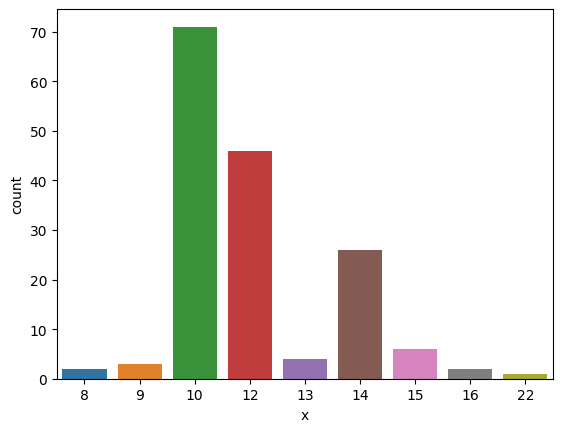

In [ ]:
data_counts = data_train.groupby('y').agg({'x': 'count'}).reset_index()
sns.countplot(data = data_counts, x = 'x')
plt.show()

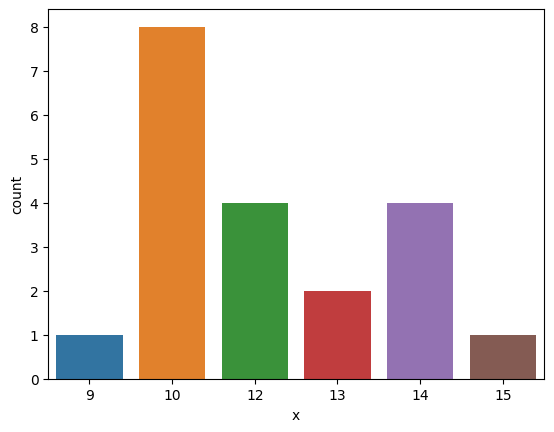

In [ ]:
data_counts = data_val.groupby('y').agg({'x': 'count'}).reset_index()
sns.countplot(data = data_counts, x = 'x')
plt.show()

* **Postprocessing** the Image, Application of **Image Augmentation** and Creation of **Generator** to read the images efficiently from the Google Drive path

In [ ]:
ps = 256

def get_image_raw(path):
    return rawpy.imread(path)


def postprocess_raw(raw):
    im = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
    im = np.float32(im) / 65535.0

    return im

def augment(images: tuple):
    assert len(images) == 2, "Need 2 images for augmentation"
    im1, im2 = images

    if random.randint(0, 1) == 1:
        im1 = np.flip(im1, axis=1)
        im2 = np.flip(im2, axis=1)

    if random.randint(0, 1) == 1:
        im1 = np.flip(im1, axis=2)
        im2 = np.flip(im2, axis=2)

    return im1, im2

def resize(im_s, im_l, ps):
    patch_s = tf.image.resize(im_s, [ps, ps], antialias = True, method = 'nearest')
    patch_l = tf.image.resize(im_l, [ps, ps], antialias = True, method = 'nearest')

    return patch_s, patch_l
  ##################################################################################################

AUTOTUNE = tf.data.experimental.AUTOTUNE
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 2
TEST_BATCH_SIZE = 24

def train_gen():
    x_paths, y_paths = data_train['x'][:1200], data_train['y'][:1200]
    for x, y in zip(x_paths, y_paths):
        yield augment(resize(postprocess_raw(get_image_raw(x)), postprocess_raw(get_image_raw(y)), ps))

ds_train = tf.data.Dataset.from_generator(
    train_gen,
    output_signature=(
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32),
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32)
    )
)

ds_train = ds_train.cache()
ds_train = ds_train.batch(TRAIN_BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

def val_gen():
    x_paths, y_paths = data_val['x'], data_val['y']
    for x, y in zip(x_paths, y_paths):
        yield resize(postprocess_raw(get_image_raw(x)), postprocess_raw(get_image_raw(y)), ps)

ds_val = tf.data.Dataset.from_generator(
    val_gen,
    output_signature=(
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32),
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32)
    )
)

ds_val = ds_val.cache()
ds_val = ds_val.batch(VAL_BATCH_SIZE)
ds_val = ds_val.prefetch(AUTOTUNE)

def test_gen():
    x_paths, y_paths = data_test['x'], data_test['y']
    for x, y in zip(x_paths, y_paths):
        yield resize(postprocess_raw(get_image_raw(x)), postprocess_raw(get_image_raw(y)), ps)

ds_test = tf.data.Dataset.from_generator(
    test_gen,
    output_signature=(
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32),
         tf.TensorSpec(shape=(None, None, 3), dtype=np.float32)
    )
)

ds_test = ds_test.batch(TEST_BATCH_SIZE)
ds_test = ds_test.prefetch(AUTOTUNE)

* Example of an Input (Short-Exposure, Dark) and Output (Long-Exposure, Bright ; Ground Truth) Image

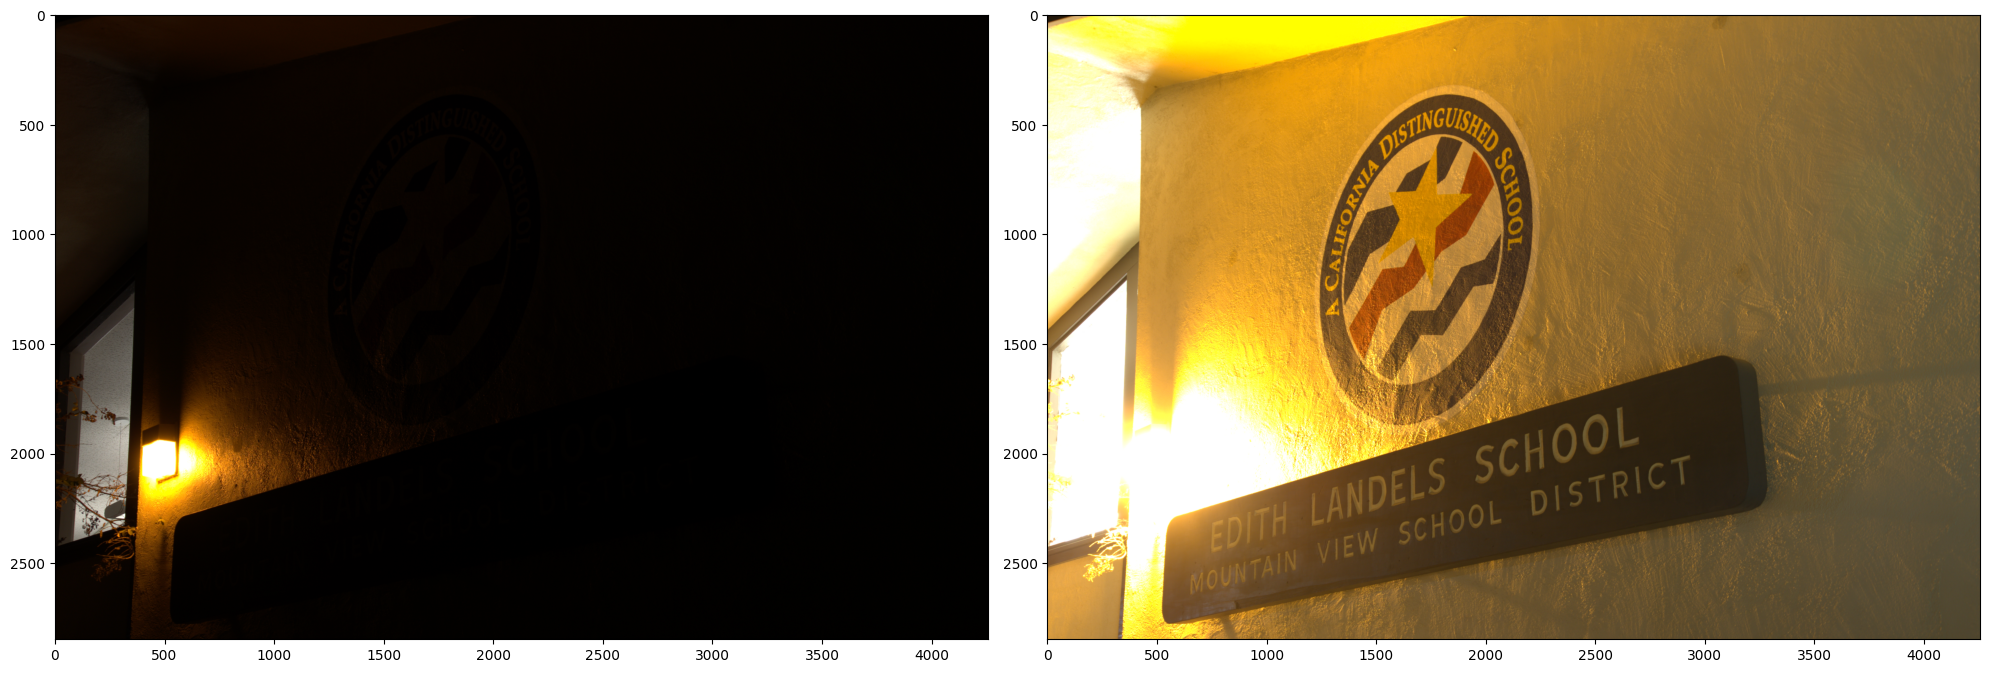

In [ ]:
temp_x = data_train['x'][300]
temp_y = data_train['y'][300]

im1 = get_image_raw(temp_x)
im1 = postprocess_raw(im1)

im2 = get_image_raw(temp_y)
im2 = postprocess_raw(im2)

fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(im1)
ax[1].imshow(im2)
plt.tight_layout()
plt.show()

* Method for Performance Metrics:

>1. **Peak Signal-to-Noise Ratio (PSNR)**
>2. **Structural Similarity (SSIM)**

In [ ]:
def PSNR(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    psnr = 10.0 * tf.math.log((1.0 ** 2) / mse) / tf.math.log(10.)
    return psnr

def SSIM(y_true, y_hat):
    K1 = 0.01
    K2 = 0.03
    L = 65535.0

    image1 = y_true
    image2 = y_hat

    # Mean of the images
    mu1 = tf.reduce_mean(image1)
    mu2 = tf.reduce_mean(image2)

    # Variance of the images
    var1 = tf.reduce_mean(tf.square(image1 - mu1))
    var2 = tf.reduce_mean(tf.square(image2 - mu2))

    # Covariance between the images
    covar = tf.reduce_mean((image1 - mu1) * (image2 - mu2))

    # Calculate SSIM
    c1 = (K1 * L) ** 2
    c2 = (K2 * L) ** 2
    numerator = (2 * mu1 * mu2 + c1) * (2 * covar + c2)
    denominator = (mu1 ** 2 + mu2 ** 2 + c1) * (var1 + var2 + c2)

    ssim = numerator / denominator

    return ssim

def plot_pair(x, y, y_h):
    fig, ax = plt.subplots(1, 3, figsize = (10, 5))
    ax[0].imshow(x)
    ax[1].imshow(y)
    ax[2].imshow(y_h)
    plt.tight_layout()
    plt.show()

# Fully Connected U-Net Model

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, (3, 3), padding = "same", activation = 'relu', kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = Conv2D(n_filters, (3, 3), padding = "same", activation = 'relu', kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p =  MaxPooling2D(pool_size=(2, 2))(f)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = UpSampling2D(size=(2, 2))(x)
   # concatenate
   x = concatenate([x, conv_features])
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

def SubpixelUpsampling(x, y):
    depth = tf.keras.backend.int_shape(x)[-1]
    def depth_to_space(x):
          return tf.nn.depth_to_space(x, 3)
    x = Conv2D(filters=depth*2, kernel_size=(1,1), strides=1, padding='same', )(x)
    x = Lambda(depth_to_space)(x)
    x = concatenate([x, y])
    return x


def model():
 # inputs
   inputs = Input(shape=(256, 256, 3))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   final = Conv2D(3, 1, activation = 'relu')(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, final, name="U-Net")

   return unet_model

* Creating the Deep Learning Model and Compile

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.MeanAbsoluteError(),
              metrics = [PSNR, SSIM])

In [ ]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

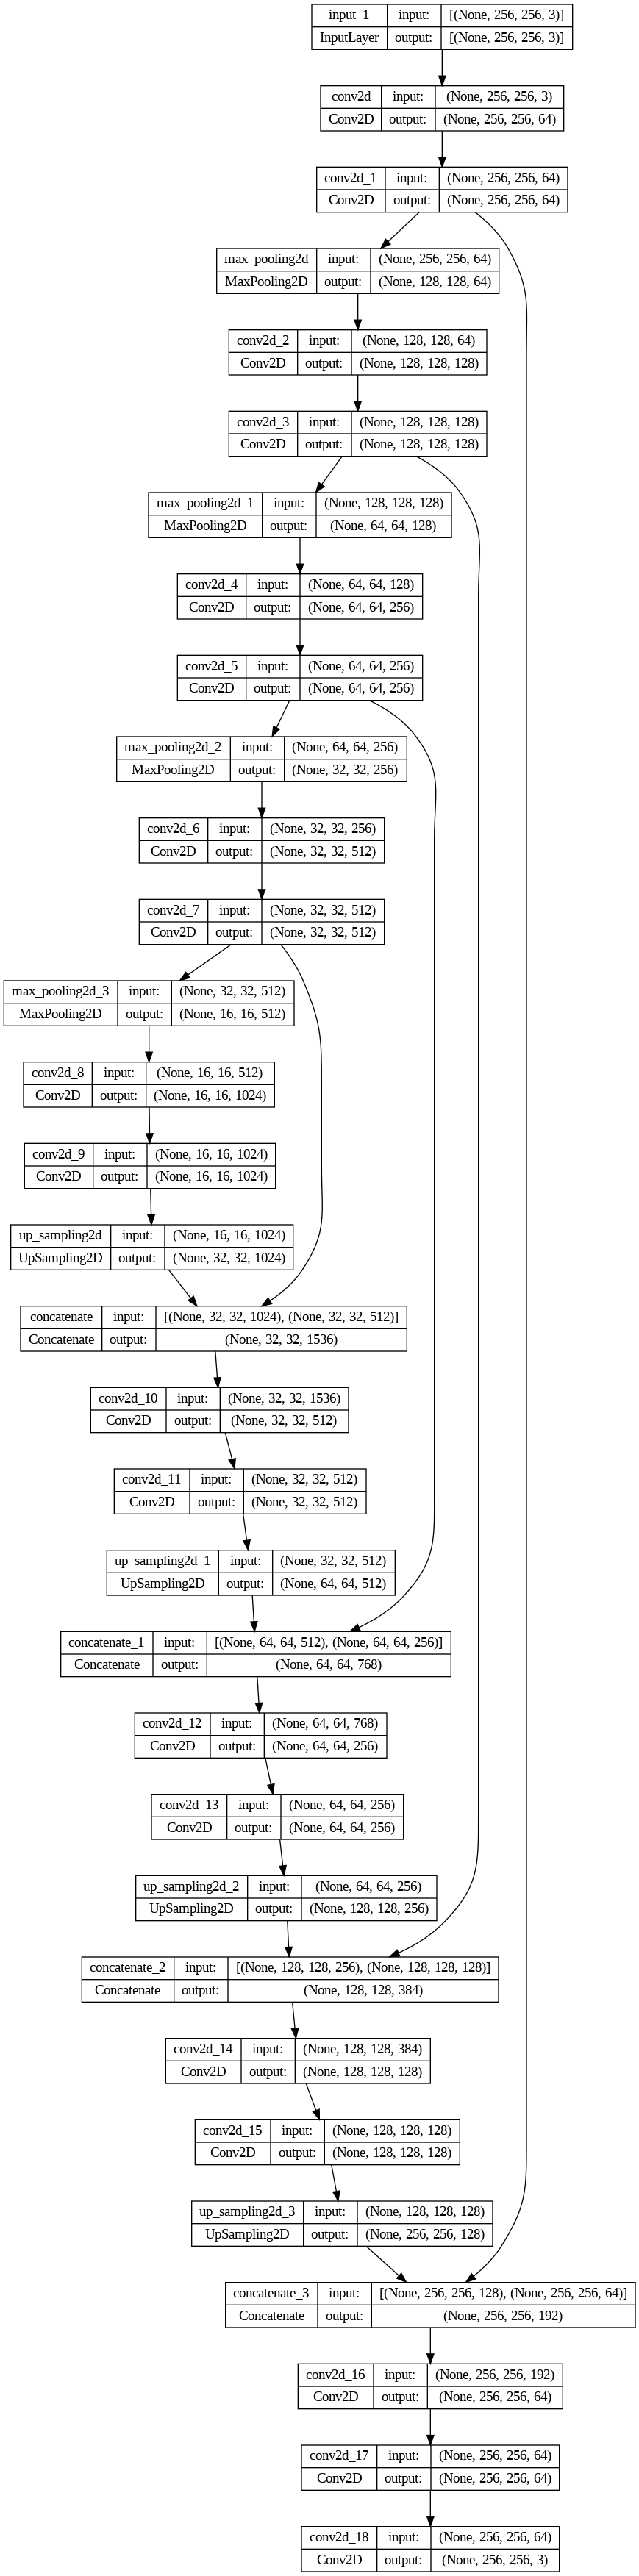

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

* Callback Functions

In [ ]:
# 1 GPU
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 3,
    min_lr = 1e-7
)

!mkdir 'training'
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

n_batches = data_train.shape[0] // TRAIN_BATCH_SIZE

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True)

# Training the Model

1. Starting with 2-Epochs

In [ ]:
hist = model.fit(
    x = ds_train,
    epochs = 2,
    validation_data = ds_val,
    callbacks=[reduce_lr, cp_callback]
)

Epoch 1/2
    300/Unknown - 4861s 16s/step - loss: 0.3435 - PSNR: 18.0859 - SSIM: 1.0000
Epoch 1: saving model to /content/training/cp-0001.ckpt
300/300 [==============================] - 5826s 19s/step - loss: 0.3435 - PSNR: 18.0859 - SSIM: 1.0000 - val_loss: 0.1436 - val_PSNR: 18.4326 - val_SSIM: 1.0000 - lr: 0.0010
Epoch 2/2
300/300 [==============================] - ETA: 0s - loss: 0.0956 - PSNR: inf - SSIM: 1.0000
Epoch 2: saving model to /content/training/cp-0002.ckpt
300/300 [==============================] - 73s 242ms/step - loss: 0.0956 - PSNR: inf - SSIM: 1.0000 - val_loss: 0.1355 - val_PSNR: 18.7953 - val_SSIM: 1.0000 - lr: 0.0010


* Mid-Training Sanity Check

1/1 [==============================] - 2s 2s/step


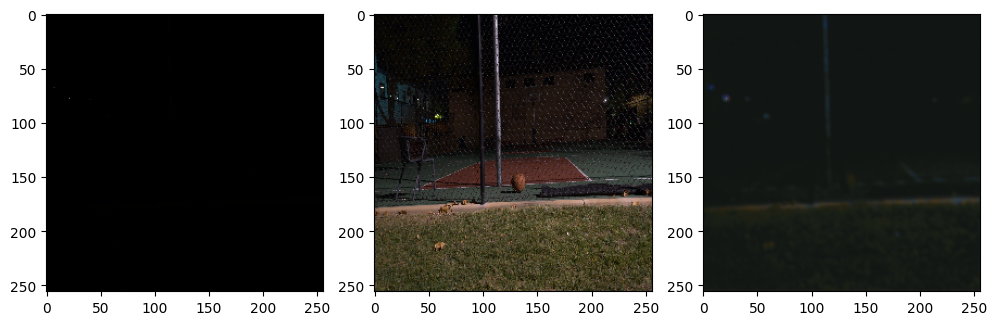

1/1 [==============================] - 0s 21ms/step


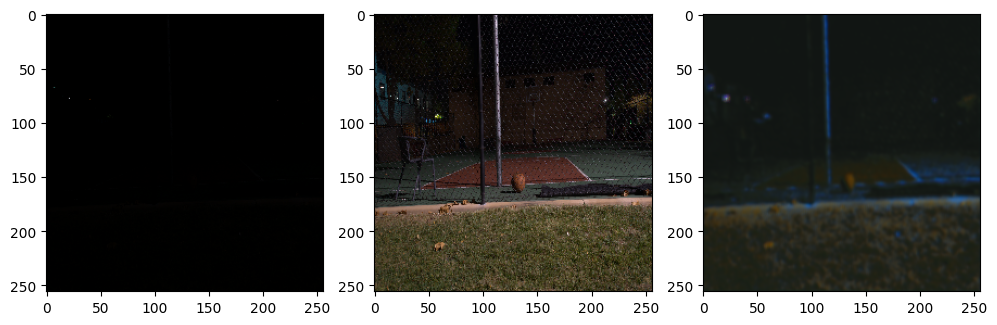

1/1 [==============================] - 0s 38ms/step


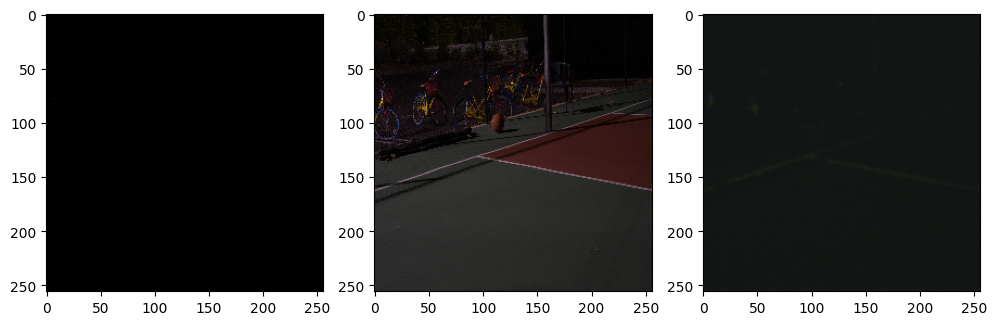

1/1 [==============================] - 0s 24ms/step


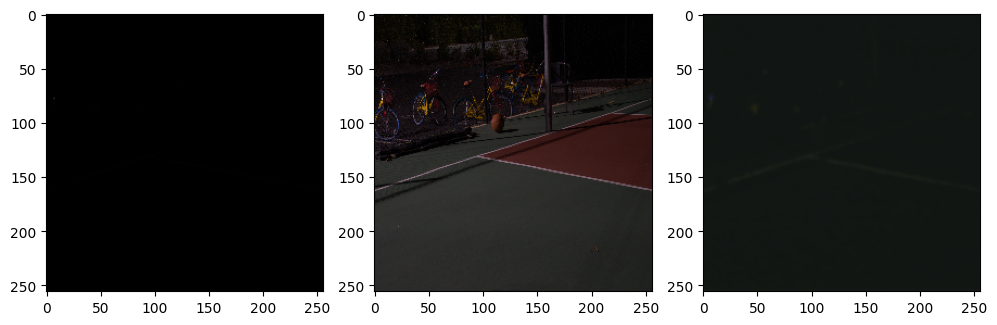

In [ ]:
test_batch = next(iter(ds_test))

t = model.predict(tf.expand_dims(test_batch[0][0], axis = 0))[0]
plot_pair(test_batch[0][0], test_batch[1][0], t)

t = model.predict(tf.expand_dims(test_batch[0][1], axis = 0))[0]
plot_pair(test_batch[0][1], test_batch[1][1], t)

t = model.predict(tf.expand_dims(test_batch[0][14], axis = 0))[0]
plot_pair(test_batch[0][14], test_batch[1][14], t)

t = model.predict(tf.expand_dims(test_batch[0][14], axis = 0))[0]
plot_pair(test_batch[0][15], test_batch[1][15], t)

2. Proceed with next 8 Epochs

In [ ]:
hist = model.fit(
    x=ds_train,
    epochs = 10,
    validation_data=ds_val,
    callbacks=[reduce_lr, cp_callback],
    initial_epoch = 2
)

Epoch 3/10
    300/Unknown - 67s 223ms/step - loss: 0.0878 - PSNR: inf - SSIM: 1.0000
Epoch 3: saving model to /content/training/cp-0003.ckpt
300/300 [==============================] - 74s 246ms/step - loss: 0.0878 - PSNR: inf - SSIM: 1.0000 - val_loss: 0.1184 - val_PSNR: 19.8978 - val_SSIM: 1.0000 - lr: 0.0010
Epoch 4/10
300/300 [==============================] - ETA: 0s - loss: 0.0822 - PSNR: inf - SSIM: 1.0000
Epoch 4: saving model to /content/training/cp-0004.ckpt
300/300 [==============================] - 77s 255ms/step - loss: 0.0822 - PSNR: inf - SSIM: 1.0000 - val_loss: 0.1121 - val_PSNR: 20.3485 - val_SSIM: 1.0000 - lr: 0.0010
Epoch 5/10
300/300 [==============================] - ETA: 0s - loss: 0.0839 - PSNR: 23.8196 - SSIM: 1.0000
Epoch 5: saving model to /content/training/cp-0005.ckpt
300/300 [==============================] - 77s 257ms/step - loss: 0.0839 - PSNR: 23.8196 - SSIM: 1.0000 - val_loss: 0.1152 - val_PSNR: 20.2134 - val_SSIM: 1.0000 - lr: 0.0010
Epoch 6/10
300/30

# Inference after 10 Epochs

1/1 [==============================] - 0s 37ms/step


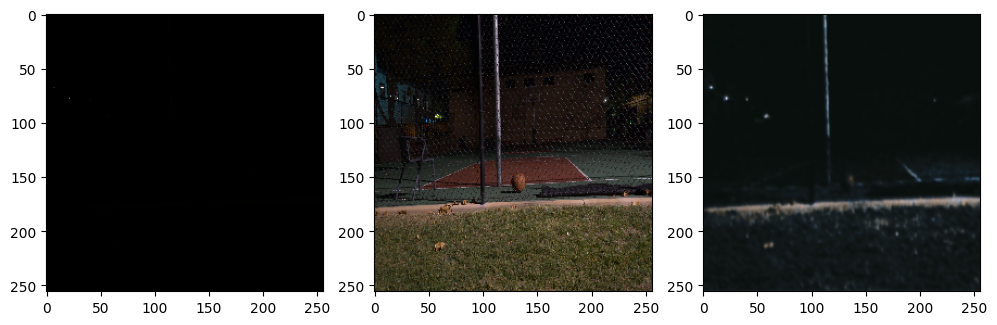

1/1 [==============================] - 0s 32ms/step


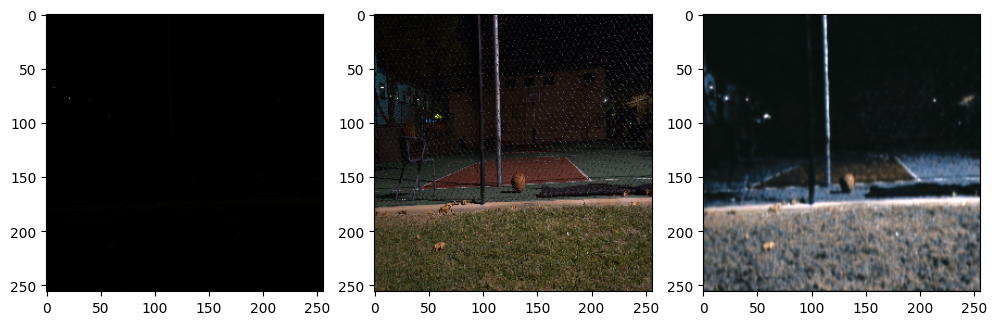

1/1 [==============================] - 0s 27ms/step


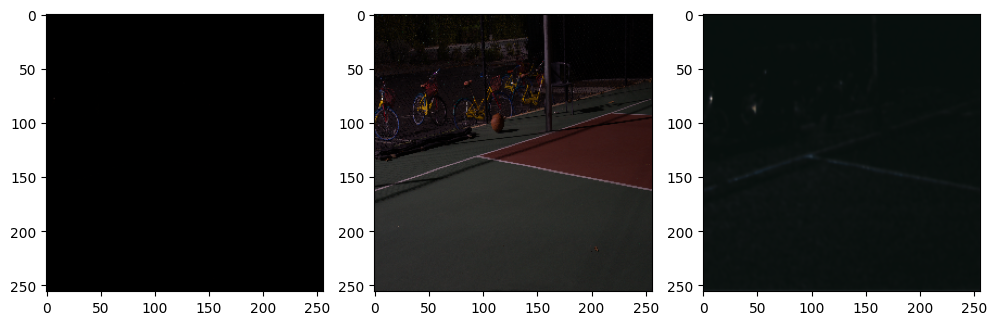

1/1 [==============================] - 0s 33ms/step


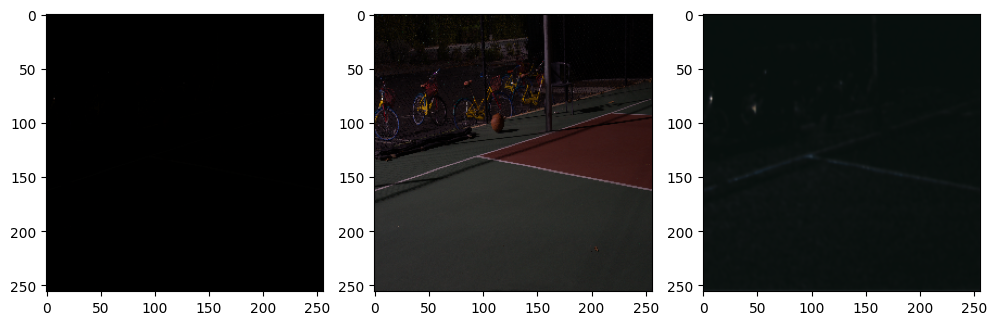

In [ ]:
t = model.predict(tf.expand_dims(test_batch[0][0], axis = 0))[0]
plot_pair(test_batch[0][0], test_batch[1][0], t)

t = model.predict(tf.expand_dims(test_batch[0][1], axis = 0))[0]
plot_pair(test_batch[0][1], test_batch[1][1], t)

t = model.predict(tf.expand_dims(test_batch[0][14], axis = 0))[0]
plot_pair(test_batch[0][14], test_batch[1][14], t)

t = model.predict(tf.expand_dims(test_batch[0][14], axis = 0))[0]
plot_pair(test_batch[0][15], test_batch[1][15], t)

In [ ]:
model.save('SID_Model_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!cp /content/SID_Model_1.h5 /content/drive/MyDrive/Scaler/Project/DSML_Portfolio_Project/

3. Proceed with next 30 Epochs

In [ ]:
hist = model.fit(
    x=ds_train,
    epochs = 40,
    validation_data=ds_val,
    callbacks=[reduce_lr, cp_callback],
    initial_epoch = 10
)

Epoch 11/40
    300/Unknown - 70s 234ms/step - loss: 0.0750 - PSNR: 24.3596 - SSIM: 1.0000
Epoch 11: saving model to /content/training/cp-0011.ckpt
300/300 [==============================] - 79s 262ms/step - loss: 0.0750 - PSNR: 24.3596 - SSIM: 1.0000 - val_loss: 0.1390 - val_PSNR: 18.4608 - val_SSIM: 1.0000 - lr: 2.0000e-04
Epoch 12/40
300/300 [==============================] - ETA: 0s - loss: 0.0718 - PSNR: 24.8916 - SSIM: 1.0000
Epoch 12: saving model to /content/training/cp-0012.ckpt
300/300 [==============================] - 77s 256ms/step - loss: 0.0718 - PSNR: 24.8916 - SSIM: 1.0000 - val_loss: 0.1371 - val_PSNR: 18.5135 - val_SSIM: 1.0000 - lr: 2.0000e-04
Epoch 13/40
300/300 [==============================] - ETA: 0s - loss: 0.0705 - PSNR: 25.1326 - SSIM: 1.0000
Epoch 13: saving model to /content/training/cp-0013.ckpt
300/300 [==============================] - 77s 256ms/step - loss: 0.0705 - PSNR: 25.1326 - SSIM: 1.0000 - val_loss: 0.1330 - val_PSNR: 18.7910 - val_SSIM: 1.0000 

# Inference after 40 Epochs

1/1 [==============================] - 0s 43ms/step


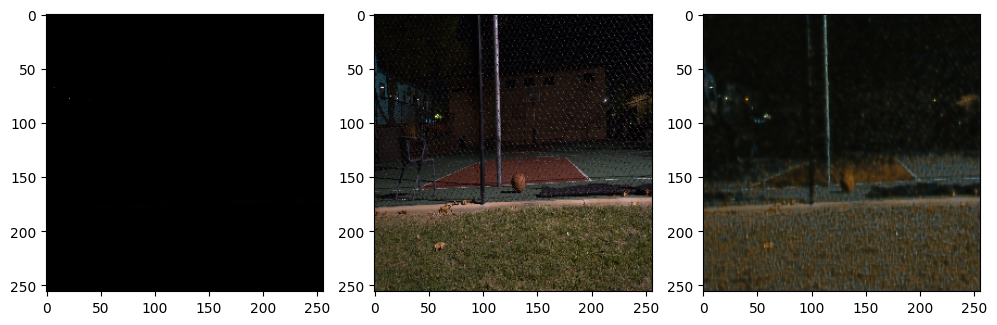

1/1 [==============================] - 0s 31ms/step


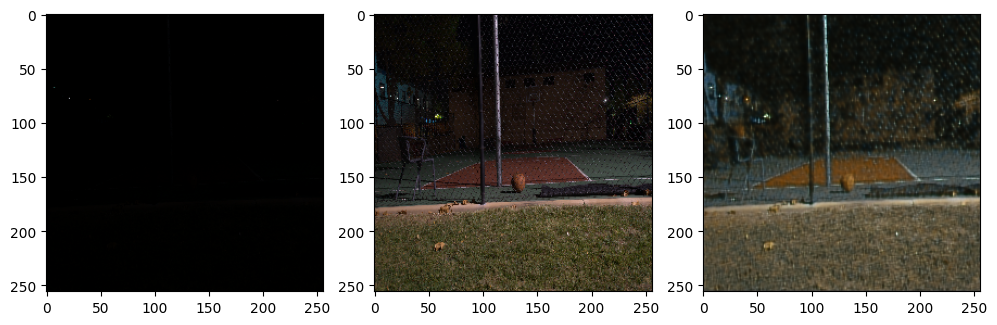

1/1 [==============================] - 0s 36ms/step


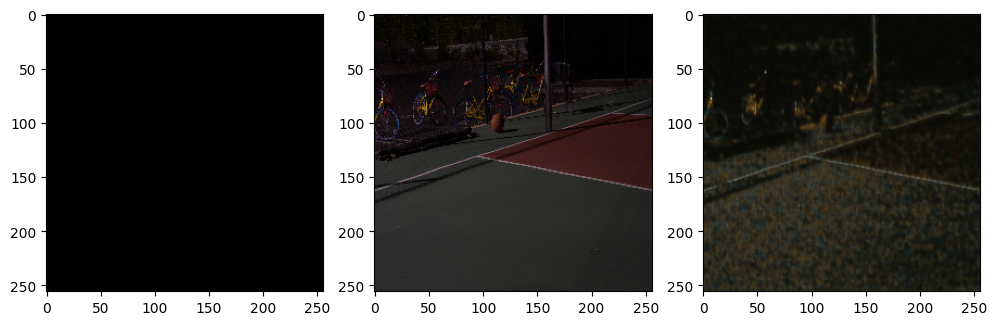

1/1 [==============================] - 0s 36ms/step


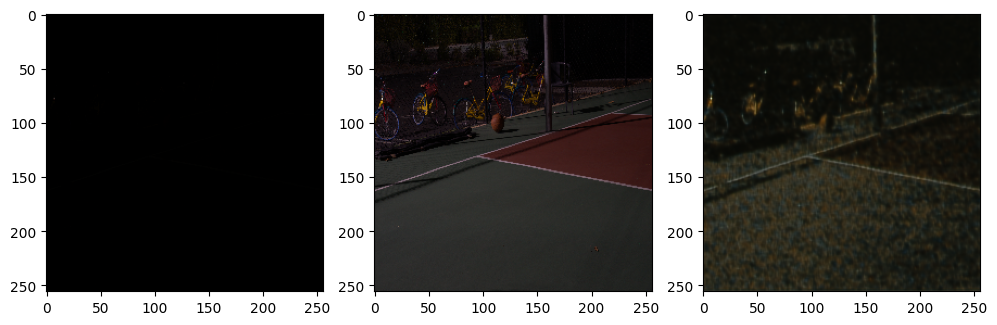

In [ ]:
t = model.predict(tf.expand_dims(test_batch[0][0], axis = 0))[0]
plot_pair(test_batch[0][0], test_batch[1][0], t)

t = model.predict(tf.expand_dims(test_batch[0][1], axis = 0))[0]
plot_pair(test_batch[0][1], test_batch[1][1], t)

t = model.predict(tf.expand_dims(test_batch[0][14], axis = 0))[0]
plot_pair(test_batch[0][14], test_batch[1][14], t)

t = model.predict(tf.expand_dims(test_batch[0][14], axis = 0))[0]
plot_pair(test_batch[0][15], test_batch[1][15], t)

4. Proceed with next 20 Epochs

In [ ]:
hist = model.fit(
    x=ds_train,
    epochs = 60,
    validation_data=ds_val,
    callbacks=[reduce_lr, cp_callback],
    initial_epoch = 40
)

Epoch 41/60
    300/Unknown - 70s 232ms/step - loss: 0.0718 - PSNR: 24.8447 - SSIM: 1.0000
Epoch 41: saving model to /content/training/cp-0041.ckpt
300/300 [==============================] - 76s 254ms/step - loss: 0.0718 - PSNR: 24.8447 - SSIM: 1.0000 - val_loss: 0.0901 - val_PSNR: 22.2337 - val_SSIM: 1.0000 - lr: 8.0000e-06
Epoch 42/60
300/300 [==============================] - ETA: 0s - loss: 0.0712 - PSNR: 25.0097 - SSIM: 1.0000
Epoch 42: saving model to /content/training/cp-0042.ckpt
300/300 [==============================] - 76s 254ms/step - loss: 0.0712 - PSNR: 25.0097 - SSIM: 1.0000 - val_loss: 0.0898 - val_PSNR: 22.2938 - val_SSIM: 1.0000 - lr: 8.0000e-06
Epoch 43/60
300/300 [==============================] - ETA: 0s - loss: 0.0709 - PSNR: 25.0855 - SSIM: 1.0000
Epoch 43: saving model to /content/training/cp-0043.ckpt
300/300 [==============================] - 76s 255ms/step - loss: 0.0709 - PSNR: 25.0855 - SSIM: 1.0000 - val_loss: 0.0898 - val_PSNR: 22.3230 - val_SSIM: 1.0000 

# Inference after 60 Epochs

1/1 [==============================] - 0s 35ms/step


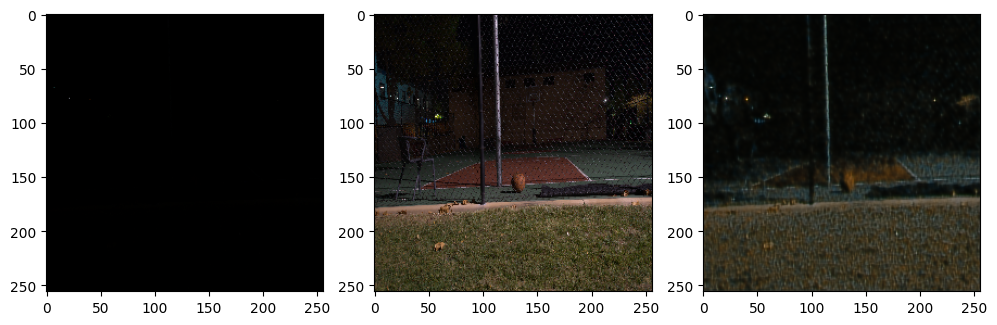

1/1 [==============================] - 0s 32ms/step


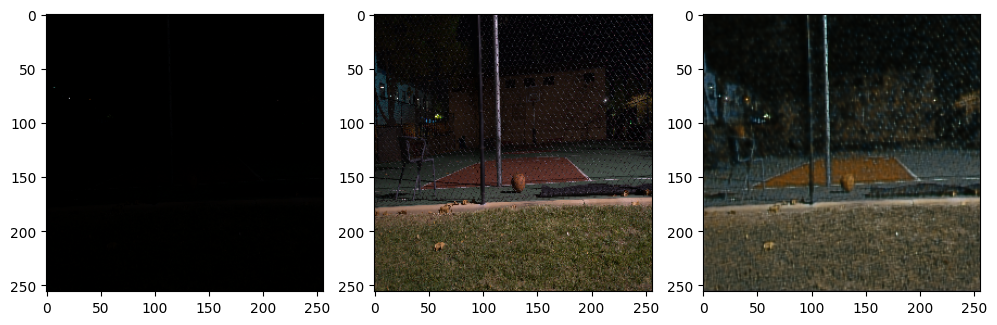

1/1 [==============================] - 0s 38ms/step


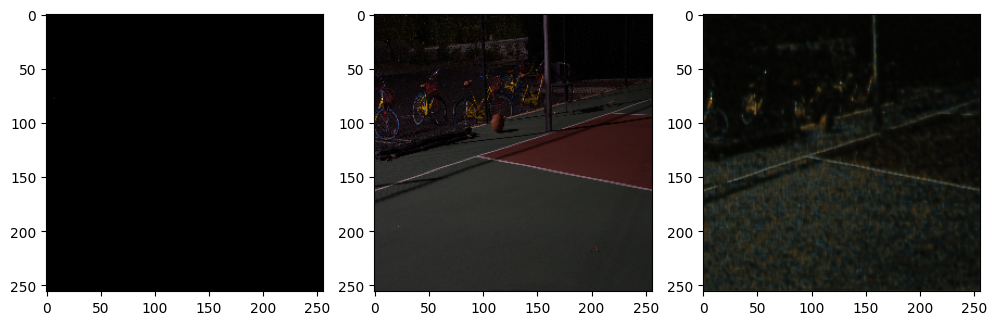

1/1 [==============================] - 0s 34ms/step


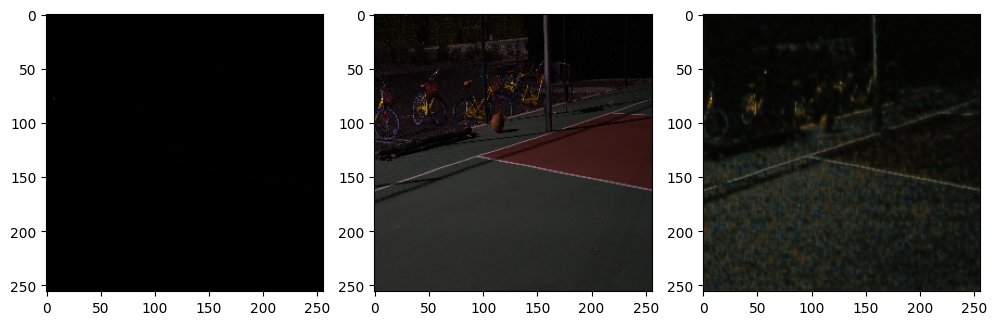

In [ ]:
t = model.predict(tf.expand_dims(test_batch[0][0], axis = 0))[0]
plot_pair(test_batch[0][0], test_batch[1][0], t)

t = model.predict(tf.expand_dims(test_batch[0][1], axis = 0))[0]
plot_pair(test_batch[0][1], test_batch[1][1], t)

t = model.predict(tf.expand_dims(test_batch[0][14], axis = 0))[0]
plot_pair(test_batch[0][14], test_batch[1][14], t)

t = model.predict(tf.expand_dims(test_batch[0][14], axis = 0))[0]
plot_pair(test_batch[0][15], test_batch[1][15], t)

In [ ]:
model.save('SID_Model_2.h5')

# Model Evaluation

In [ ]:
results = model.evaluate(x=ds_test)
print("Testing Results: ")
print(f"MAE: {results[0]}")
print(f"PSNR: {results[1]}")
print(f"SSIM: {results[2]}")

25/25 [==============================] - 2472s 99s/step - loss: 0.0808 - PSNR: 23.8146 - SSIM: 1.0000
Testing Results: 
MAE: 0.08078000694513321
PSNR: 23.814620971679688
SSIM: 1.0


In [ ]:
Training_Loss = [0.1923, 0.0949, 0.0858, 0.0834, 0.0814, 0.0780, 0.0773, 0.0723, 0.0725, 0.0726, 0.0771, 0.0734, 0.0723, 0.0716, 0.0712, 0.0708, 0.0761, 0.0712, 0.0705, 0.0703, 0.0701, 0.0700, 0.0705, 0.0700, 0.0698, 0.0697, 0.0697, 0.0696, 0.0696, 0.0696, 0.0695, 0.0695, 0.0695, 0.0694, 0.0694, 0.0694, 0.0694, 0.0694, 0.0694, 0.0694]
Validation_Loss = [0.1405, 0.1239, 0.1201, 0.1108, 0.1171, 0.1179, 0.1108, 0.1155, 0.1182, 0.1201, 0.1071, 0.1045, 0.1041, 0.1044, 0.1049, 0.1054, 0.0979, 0.0972, 0.0971, 0.0971, 0.0971, 0.0971, 0.0967, 0.0966, 0.0965, 0.0965, 0.0964, 0.0964, 0.0964, 0.0964, 0.0964, 0.0964, 0.0964, 0.0964, 0.0964, 0.0964, 0.0964, 0.0964, 0.0964, 0.0964]

Training_PSNR = [22.3782, 23.4817, 23.8884, 24.3234, 24.3319, 24.9212, 25.1151, 25.0893, 24.2850, 24.8299, 25.0356, 25.1353, 25.2044, 25.2634, 24.3241, 25.1933, 25.3595, 25.4188, 25.4534, 25.4779, 25.1715, 25.3584, 25.4530, 25.5058, 25.5378, 25.5584, 25.5726, 25.5830, 25.5396, 25.5487, 25.5568, 25.5539, 25.5565, 25.5589, 25.5613, 25.5635, 25.5658, 25.5679]
Validation_PSNR = [20.0211, 20.7255, 20.3196, 20.5219, 20.8139, 20.4300, 20.2267, 20.1225, 20.8234, 21.0457, 21.1080, 21.1062, 21.0875, 21.0517, 21.9019, 22.0301, 22.0733, 22.0959, 22.1080, 22.1147, 22.2475, 22.3135, 22.3498, 22.3714, 22.38551, 22.3944, 22.4011, 22.4063, 22.4116, 22.4163, 22.4205, 22.4219, 22.4233, 22.4247, 22.4260, 22.4273, 22.4285, 22.4297]

* Plot for Training and Validation Loss vs. Epochs

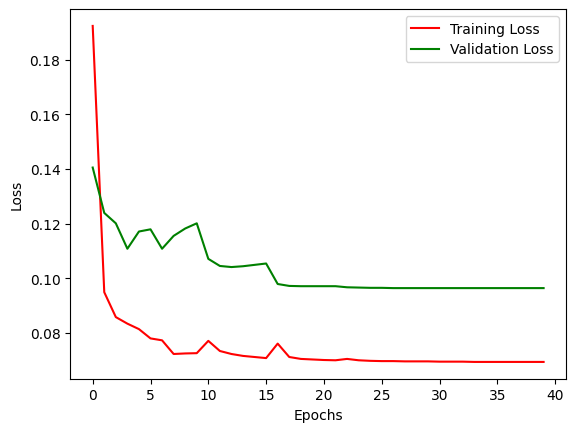

In [ ]:
plt.plot(Training_Loss, label='Training Loss', c='red')
plt.plot(Validation_Loss, label='Validation Loss', c='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

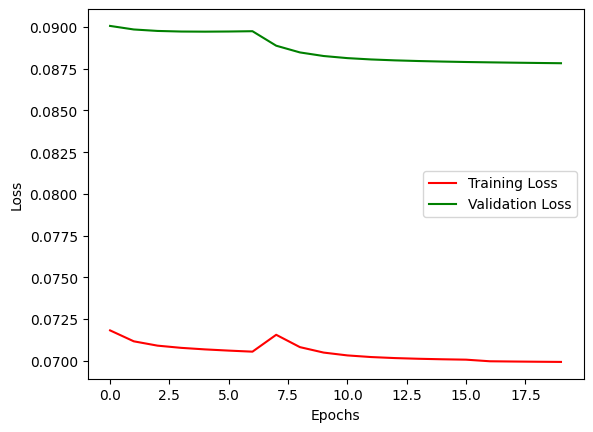

In [ ]:
plt.plot(hist.history['loss'], label='Training Loss', c='red')
plt.plot(hist.history['val_loss'], label='Validation Loss', c='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Plot for Training and Validation PSNR vs. Epochs

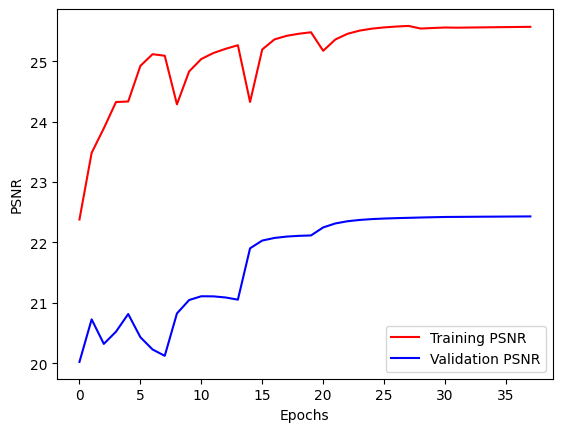

In [ ]:
plt.plot(Training_PSNR, label='Training PSNR', c='red')
plt.plot(Validation_PSNR, label='Validation PSNR', c='blue')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.show()

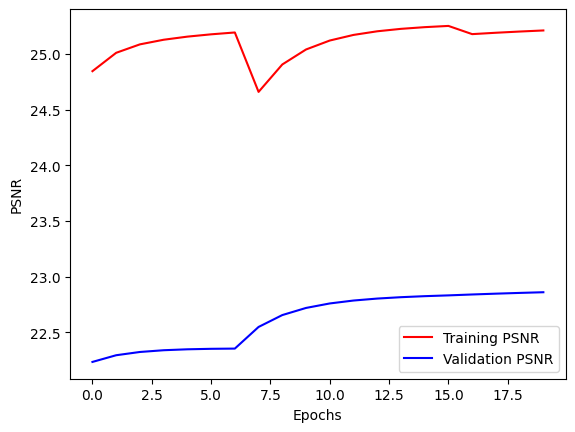

In [ ]:
plt.plot(hist.history['PSNR'], label='Training PSNR', c='red')
plt.plot(hist.history['val_PSNR'], label='Validation PSNR', c='blue')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.show()

* Saving the Pre-Trained Model for further usage

In [ ]:
!cp /content/SID_Model_2.h5 /content/drive/MyDrive/Scaler/Project/DSML_Portfolio_Project/